In [1]:
from plots.mpltoolkit import named_colors, mpl_loc, markers, fancy_legend, load_mpl_presets
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import random
import vice
import sys
sys.path.append("..")
from src.stats import skewnormal_mode_sample, jackknife_summary_statistic
load_mpl_presets()
mpl.rcParams["axes.linewidth"] = 0.5
mpl.rcParams["figure.titlesize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 14
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)


In [2]:
columns = ["LINE", "APOGEE_ID", "RA", "DEC", "GALR", "GALPHI", "GALZ", "SNREV", "TEFF", "TEFF_ERR",
    "LOGG", "LOGG_ERR", "FE_H", "FE_H_ERR", "O_FE", "O_FE_ERR", "ASTRONN_AGE", "ASTRONN_AGE_ERR",
    "LATENT_AGE", "LATENT_AGE_ERR"]
raw = np.genfromtxt("../data/Leung2023.csv", delimiter = ',', skip_header = 1, usecols = range(len(columns)))
sample = {}
for i in range(len(columns)):
    sample[columns[i]] = [row[i] for row in raw]
sample["o_h"] = [a + b for a, b in zip(sample["O_FE"], sample["FE_H"])]
sample["o_h_err"] = [np.sqrt(a**2 + b**2) for a, b in zip(sample["O_FE_ERR"], sample["FE_H_ERR"])]
sample["absz"] = [abs(_) for _ in sample["GALZ"]]
sample = vice.dataframe(sample)
sample = sample.filter("absz", "<=", 0.5)
print(sample)

vice.dataframe{
    line -----------> [0, 1, 2, ... , 192917, 192918, 192919]
    apogee_id ------> [nan, nan, nan, ... , nan, nan, nan]
    ra -------------> [0.00285, 0.005558, 0.008802, ... , 359.993, 359.995, 359.997]
    dec ------------> [57.1732, 57.3545, 63.4631, ... , 57.0124, 57.435, 56.1633]
    galr -----------> [8.4584, 11.9539, 12.8583, ... , 10.6942, 9.3281, 9.64501]
    galphi ---------> [175.658, 153.655, 151.397, ... , 159.022, 167.511, 165.095]
    galz -----------> [-0.040749, -0.470835, 0.169356, ... , -0.358826, -0.163006, -0.265258]
    snrev ----------> [282.746, 120.295, 169.02, ... , 101.537, 232.918, 88.4561]
    teff -----------> [5031.26, 4974.6, 4681.46, ... , 4954.17, 4859.91, 4585.41]
    teff_err -------> [10.1451, 15.3109, 8.76634, ... , 15.7503, 9.05073, 11.2989]
    logg -----------> [3.45613, 2.38825, 2.24553, ... , 2.47466, 2.48069, 2.57144]
    logg_err -------> [0.0235541, 0.0355173, 0.0243345, ... , 0.0347484, 0.0240131, 0.0286862]
    fe_h ----

In [3]:
class line:

    def __init__(self, slope, intercept):
        self.slope = slope
        self.intercept = intercept

    def __call__(self, x):
        return self.slope * x + self.intercept

    def __repr__(self):
        return "line(slope = %.2e +/- %.2e, intercept = %.2e +/- %.2e, rvalue = %.2e, pvalue = %.3e)" % (
            self.slope, self.stderr, self.intercept, self.intercept_stderr,
            self.rvalue, self.pvalue)

    @classmethod
    def from_scipy_linregress(cls, result):
        obj = cls(result.slope, result.intercept)
        obj.rvalue = result.rvalue
        obj.pvalue = result.pvalue
        obj.stderr = result.stderr
        obj.intercept_stderr = result.intercept_stderr
        return obj

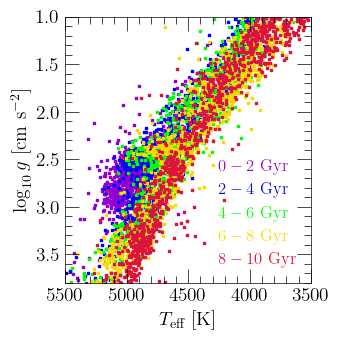

In [16]:
AGE_BINS = [0, 2, 4, 6, 8, 10]
COLORS = ["darkviolet", "blue", "lime", "gold", "crimson"]
N_SAMPLE = 1000
SEED = 1

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$T_\text{eff}$ [K]")
ax.set_ylabel(r"$\log_{10} g$ [cm s$^{-2}$]")
ax.set_xlim([3500, 5500])
ax.set_ylim([1, 3.8])
ax.invert_xaxis()
ax.invert_yaxis()

random.seed(a = SEED)
for i in range(len(AGE_BINS) - 1):
    sub = sample.filter(
        "astronn_age", ">=", AGE_BINS[i]).filter(
        "astronn_age", "<=", AGE_BINS[i + 1])
    indices = random.sample(range(len(sub["teff"])), N_SAMPLE)
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "s": 1,
        "marker": markers()["pixel"],
        "rasterized": True,
        "label": r"$%d - %d$ Gyr" % (AGE_BINS[i], AGE_BINS[i + 1])
    }
    teff = [sub["teff"][idx] for idx in indices]
    logg = [sub["logg"][idx] for idx in indices]
    ax.scatter(teff, logg, **kwargs)

kwargs = {
    "loc": mpl_loc("lower right"),
    "handlelength": 0,
    "fontsize": 12,
    "ncol": 1
}
leg = ax.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/kiel-diagram.%s" % (ext), **kwargs)
plt.show()

In [32]:
OUTFILE = "./empirical/skewnormfits-binned-by-radius.out"
RGAL_BINS = list(range(16))

def percentiles(arr):
    ordered = np.sort(arr)
    return [ordered[int(0.16 * len(ordered))], ordered[int(0.84 * len(ordered))]]

with open(OUTFILE, 'w') as out:
    out.write("# Rgal_min [kpc]    Rgal_max [kpc]    ")
    out.write("mode([O/H])    mode([O/H])_err    ")
    out.write("[O/H]_16th    [O/H]_84th    ")
    out.write("mode([Fe/H])    mode([Fe/H])_err    ")
    out.write("[Fe/H]_16th    [Fe/H]_84th\n")
    for i in range(len(RGAL_BINS) - 1):
        sys.stdout.write("\ri = %d    " % (i))
        sub = sample.filter(
            "galr", ">=", RGAL_BINS[i]).filter(
            "galr", "<=", RGAL_BINS[i + 1])
        mode_oh = skewnormal_mode_sample(sub["o_h"])
        mode_oh_err = jackknife_summary_statistic(sub["o_h"], skewnormal_mode_sample, n_resamples = 25)
        oh_16th, oh_84th = percentiles(sub["o_h"])
        mode_feh = skewnormal_mode_sample(sub["fe_h"])
        mode_feh_err = jackknife_summary_statistic(sub["fe_h"], skewnormal_mode_sample, n_resamples = 25)
        feh_16th, feh_84th = percentiles(sub["fe_h"])
        out.write("%.3e\t%.3e\t" % (RGAL_BINS[i], RGAL_BINS[i + 1]))
        out.write("%.3e\t%.3e\t" % (mode_oh, mode_oh_err))
        out.write("%.3e\t%.3e\t" % (oh_16th, oh_84th))
        out.write("%.3e\t%.3e\t" % (mode_feh, mode_feh_err))
        out.write("%.3e\t%.3e\n" % (feh_16th, feh_84th))
    sys.stdout.write("\n")
    out.close()

i = 14    


line(slope = -6.20e-02 +/- 1.49e-03, intercept = 5.24e-01 +/- 1.29e-02, rvalue = -9.96e-01, pvalue = 3.191e-15)
line(slope = -7.00e-02 +/- 3.02e-03, intercept = 5.41e-01 +/- 2.62e-02, rvalue = -9.88e-01, pvalue = 5.907e-12)


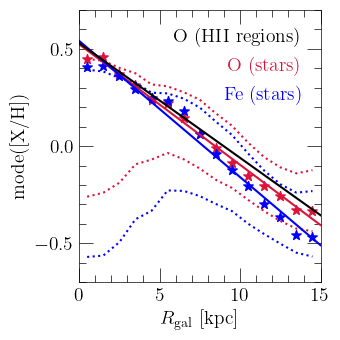

In [33]:
OUTFILE = "./empirical/skewnormfits-binned-by-radius.out"
RGAL_BINS = list(range(16))
COLORS = {
    "o": "crimson",
    "fe": "blue"
}

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"mode([X/H])")
ax.set_xlim([0, 15])
ax.set_ylim([-0.7, 0.7])
ax.set_yticks([-0.5, 0, 0.5])

hii_regions = line(-0.059, np.log10(vice.solar_z.epsilon_to_z_conversion(9.22, 15.999) / vice.solar_z['o']))
kwargs = {
    "c": named_colors()["black"],
    "label": "O (HII regions)",
    "zorder": 100
}
ax.plot(ax.get_xlim(), [hii_regions(x) for x in ax.get_xlim()], **kwargs)

raw = np.genfromtxt(OUTFILE)
centers = [(a + b) / 2 for a, b in zip(raw[:, 0], raw[:, 1])]
mode_oh = raw[:, 2]
mode_oh_err = raw[:, 3]
oh_16th = raw[:, 4]
oh_84th = raw[:, 5]
mode_feh = raw[:, 6]
mode_feh_err = raw[:, 7]
feh_16th = raw[:, 8]
feh_84th = raw[:, 9]

kwargs = {
    "c": named_colors()[COLORS["o"]],
    "marker": markers()["star"],
    "s": 50
}
ax.scatter(centers, mode_oh, **kwargs)
kwargs["c"] = named_colors()[COLORS["fe"]]
ax.scatter(centers, mode_feh, **kwargs)

kwargs = {
    "c": named_colors()[COLORS["o"]],
    "linestyle": ":"
}
ax.plot(centers, oh_16th, **kwargs)
ax.plot(centers, oh_84th, **kwargs)
kwargs["c"] = named_colors()[COLORS["fe"]]
ax.plot(centers, feh_16th, **kwargs)
ax.plot(centers, feh_84th, **kwargs)

oh_line = line.from_scipy_linregress(linregress(centers, mode_oh))
feh_line = line.from_scipy_linregress(linregress(centers, mode_feh))
kwargs = {
    "c": named_colors()[COLORS["o"]],
    "label": "O (stars)"
}
ax.plot(ax.get_xlim(), [oh_line(x) for x in ax.get_xlim()], **kwargs)
kwargs["c"] = named_colors()[COLORS["fe"]]
kwargs["label"] = "Fe (stars)"
ax.plot(ax.get_xlim(), [feh_line(x) for x in ax.get_xlim()], **kwargs)
print(oh_line)
print(feh_line)

kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0,
    "ncol": 1
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["black"] + [COLORS[key] for key in COLORS.keys()])
renderer = fig.canvas.get_renderer()
width = max([t.get_window_extent(renderer).width for t in leg.get_texts()])
for t in leg.get_texts():
    t.set_ha("right")
    shift = width - t.get_window_extent(renderer).width
    t.set_position((shift, 0))

plt.tight_layout()
plt.show()

In [23]:
OUTFILE = "./empirical/skewnormfits-binned-by-age-and-radius.out"
RGAL_BINS = list(range(16))
AGE_BINS = list(range(11))
MIN_STARS = 200

with open(OUTFILE, 'w') as out:
    out.write("# age_min [Gyr]    age_max [Gyr]    ")
    out.write("Rgal_min [kpc]    Rgal_max [kpc]    ")
    out.write("mode([O/H])    mode([O/H])_err    ")
    out.write("mode([Fe/H])    mode([Fe/H])_err\n")
    for i in range(len(AGE_BINS) - 1):
        sub = sample.filter(
            "astronn_age", ">=", AGE_BINS[i]).filter(
            "astronn_age", "<=", AGE_BINS[i + 1])
        for j in range(len(RGAL_BINS) - 1):
            subsub = sub.filter(
                "galr", ">=", RGAL_BINS[j]).filter(
                "galr", "<=", RGAL_BINS[j + 1])
            sys.stdout.write("\ri = %d ; j = %d    " % (i, j))
            if len(subsub["o_h"]) >= MIN_STARS:
                mode_oh = skewnormal_mode_sample(subsub["o_h"])
                mode_feh = skewnormal_mode_sample(subsub["fe_h"])
                mode_oh_err = jackknife_summary_statistic(subsub["o_h"], skewnormal_mode_sample, n_resamples = 25)
                mode_feh_err = jackknife_summary_statistic(subsub["fe_h"], skewnormal_mode_sample, n_resamples = 25)
            else:
                mode_oh = mode_oh_err = mode_feh = mode_feh_err = float("nan")
            out.write("%.3e\t%.3e\t" % (AGE_BINS[i], AGE_BINS[i + 1]))
            out.write("%.3e\t%.3e\t" % (RGAL_BINS[j], RGAL_BINS[j + 1]))
            out.write("%.3e\t%.3e\t" % (mode_oh, mode_oh_err))
            out.write("%.3e\t%.3e\n" % (mode_feh, mode_feh_err))
    sys.stdout.write("\n")
    out.close()

i = 9 ; j = 14    


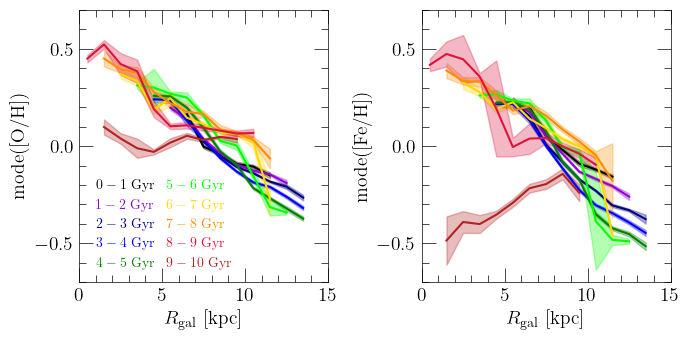

In [16]:
OUTFILE = "./empirical/skewnormfits-binned-by-age-and-radius.out"
RGAL_BINS = list(range(16))
AGE_BINS = list(range(11))
COLORS = ["black", "darkviolet", "navy", "blue", "green",
    "lime", "gold", "darkorange", "crimson", "firebrick"]

fig = plt.figure(figsize = (7, 3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for ax in [ax1, ax2]:
    ax.set_xlabel(r"$R_\text{gal}$ [kpc]", fontsize = 14)
    ax.set_xlim([0, 15])
    ax.set_xticks([0, 5, 10, 15])
    ax.set_ylim([-0.7, 0.7])
    ax.set_yticks([-0.5, 0, 0.5])
ax1.set_ylabel(r"mode([O/H])", fontsize = 14)
ax2.set_ylabel(r"mode([Fe/H])", fontsize = 14)

raw = np.genfromtxt(OUTFILE)
OH_REGRESSIONS = []
FEH_REGRESSIONS = []
for i in range(len(AGE_BINS) - 1):
    sub = []
    for row in raw:
        if row[0] == AGE_BINS[i] and row[1] == AGE_BINS[i + 1]: sub.append(row)
    rgal_min = [row[2] for row in sub]
    rgal_max = [row[3] for row in sub]
    centers = [(a + b) / 2 for a, b in zip(rgal_min, rgal_max)]
    mode_oh = [row[4] for row in sub]
    mode_oh_err = [row[5] for row in sub]
    mode_feh = [row[6] for row in sub]
    mode_feh_err = [row[7] for row in sub]
    kwargs = {
        "color": named_colors()[COLORS[i]],
        "alpha": 0.3
    }
    ax1.fill_between(centers, [a - b for a, b in zip(mode_oh, mode_oh_err)],
        [a + b for a, b in zip(mode_oh, mode_oh_err)], **kwargs)
    ax2.fill_between(centers, [a - b for a, b in zip(mode_feh, mode_feh_err)],
        [a + b for a, b in zip(mode_feh, mode_feh_err)], **kwargs)
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"$%g - %g$ Gyr" % (AGE_BINS[i], AGE_BINS[i + 1])
    }
    ax1.plot(centers, mode_oh, **kwargs)
    ax2.plot(centers, mode_feh, **kwargs)
    x1 = []
    x2 = []
    y1 = []
    y2 = []
    for i in range(len(centers)):
        if not np.isnan(mode_oh[i]):
            x1.append(centers[i])
            y1.append(mode_oh[i])
        else: pass
        if not np.isnan(mode_feh[i]):
            x2.append(centers[i])
            y2.append(mode_feh[i])
        else: pass
    OH_REGRESSIONS.append(line.from_scipy_linregress(linregress(x1, y1)))
    FEH_REGRESSIONS.append(line.from_scipy_linregress(linregress(x2, y2)))

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
    "ncol": 2,
    "fontsize": 10,
    "columnspacing": 0.5
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/gradxh-binned-by-age.%s" % (ext), **kwargs)
plt.show()

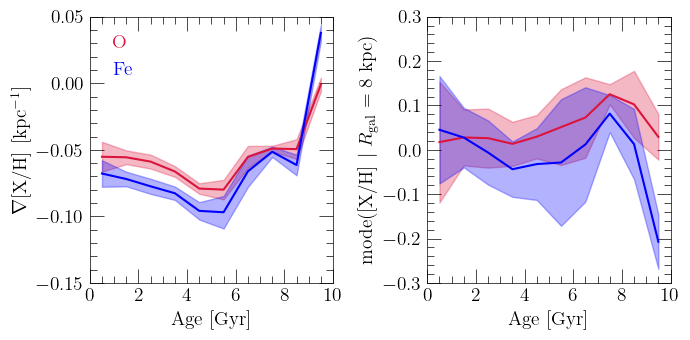

In [24]:
COLORS = {
    "o": "crimson",
    "fe": "blue"
}
REGRESSIONS = {
    "o": OH_REGRESSIONS,
    "fe": FEH_REGRESSIONS
}
BENCHMARK_RADIUS = 8 #kpc

fig = plt.figure(figsize = (7, 3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for ax in [ax1, ax2]:
    ax.set_xlabel(r"Age [Gyr]")
    ax.set_xlim([0, 10])
    ax.set_xticks([0, 2, 4, 6, 8, 10])
    ax.set_ylim([-0.3, 0.3])
ax1.set_ylabel(r"$\nabla$[X/H] [kpc$^{-1}$]")
ax1.set_ylim([-0.15, 0.05])
ax2.set_ylabel(r"mode([X/H] $|\ R_\text{gal} = %g$ kpc)" % (BENCHMARK_RADIUS))

for elem in ["o", "fe"]:
    ages = [0.5 + i for i in range(10)]
    regressions = REGRESSIONS[elem]
    slopes = [regressions[_].slope for _ in range(len(ages))]
    norms = [regressions[_](BENCHMARK_RADIUS) for _ in range(len(ages))]
    slope_errs = [regressions[_].stderr for _ in range(len(ages))]
    norm_errs = [np.sqrt(BENCHMARK_RADIUS**2 * sigm**2 + sigb**2) for sigm, sigb in zip(
        [regressions[_].stderr for _ in range(len(ages))],
        [regressions[_].intercept_stderr for _ in range(len(ages))])]
    
    kwargs = {
        "c": named_colors()[COLORS[elem]],
        "label": elem.capitalize()
    }
    ax1.plot(ages, slopes, **kwargs)
    ax1.fill_between(ages, [a + b for a, b in zip(slopes, slope_errs)],
        [a - b for a, b in zip(slopes, slope_errs)], alpha = 0.3, color = kwargs["c"])
    ax2.plot(ages, norms, **kwargs)
    ax2.fill_between(ages, [a + b for a, b in zip(norms, norm_errs)],
        [a - b for a, b in zip(norms, norm_errs)], alpha = 0.3, color = kwargs["c"])

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "ncol": 1
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, [COLORS[key] for key in COLORS.keys()])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/slopes-norms-vs-age.%s" % (ext), **kwargs)
plt.show()

What are the slopes and intercepts for $\leq 8$ Gyr old populations?
--

In [30]:
RGAL_BINS = list(range(16))

sub = sample.filter("astronn_age", "<=", 9)
mode_oh = []
mode_feh = []
for i in range(len(RGAL_BINS) - 1):
    subsub = sub.filter(
        "galr", ">=", RGAL_BINS[i]).filter(
        "galr", "<=", RGAL_BINS[i + 1])
    mode_oh.append(skewnormal_mode_sample(subsub["o_h"]))
    mode_feh.append(skewnormal_mode_sample(subsub["fe_h"]))
centers = [(a + b) / 2 for a, b in zip(RGAL_BINS[:-1], RGAL_BINS[1:])]
print(centers)
print(mode_oh)
print(mode_feh)
oh_grad = line.from_scipy_linregress(linregress(centers, mode_oh))
feh_grad = line.from_scipy_linregress(linregress(centers, mode_feh))

print(oh_grad)
print(feh_grad)

[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5]
[0.4442077608173437, 0.45170542575951866, 0.36658291249562314, 0.30970686006125825, 0.24564506964101768, 0.2254996872153548, 0.1547647340715008, 0.07191135769781704, -0.013202124110172034, -0.08917151953241022, -0.1522435028396666, -0.20242798095688178, -0.2573021883548641, -0.3278741055703262, -0.33769405952232223]
[0.3887653240275041, 0.3917043151398363, 0.33221109427414347, 0.28219007640850885, 0.24576348077785742, 0.228333869921399, 0.17863115620521178, 0.06759529868227881, -0.03568924760708704, -0.120036131953541, -0.2070439090143284, -0.3000557168675365, -0.36568492469849356, -0.45481292489271985, -0.46618267013649706]
line(slope = -6.18e-02 +/- 1.58e-03, intercept = 5.23e-01 +/- 1.37e-02, rvalue = -9.96e-01, pvalue = 7.110e-15)
line(slope = -6.84e-02 +/- 3.24e-03, intercept = 5.24e-01 +/- 2.81e-02, rvalue = -9.86e-01, pvalue = 1.942e-11)
